# YZV211E Homework 1
# Traffic Data Analysis for Maslak Area

This notebook guides you through analyzing traffic data from the Maslak area using the IBB API. You will perform data fetching, filtering, calculations, visualizations, and statistical analysis as part of the homework.

---

In [41]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
# STUDENT NAME: İbrahim Bancar
# STUDENT NUMBER: 150220313 

## **Part 1: Retrieve Traffic Data from the IBB API**

In this section, you will write a function to fetch traffic data of September 2024 from the IBB API for the Maslak area based on geohashes.
https://data.ibb.gov.tr/dataset/hourly-traffic-density-data-set/resource/914cb0b9-d941-4408-98eb-f378519c26f4

- Write a function to retrieve traffic data using the `requests` library.
- Store the data in a pandas DataFrame.
- Be careful about the data fetch limit of the API (limit = 500).
- Do not use solutions such as giving manual offsets etc. It means that your codes should also work  with different geohash lists. 

In [43]:
# Function to retrieve data from the IBB API and return it as a DataFrame
def get_maslak_traffic_data(resource_id, geohash_value, limit=500):
    """
    Params:
        resource_id: resource if for the API, check the IBB API documentation
        geohash_value: GEOHASH value for Maslak
        limit: shows the limit for the API, you dont need to change it
    """
    offset = 0  # Initialize offset 
    data = list()  # List to store all fetched data

    while True:
        # Send a GET request to the IBB API to retrieve data
        response = requests.get("https://data.ibb.gov.tr/api/3/action/datastore_search",params={
                "resource_id":resource_id,  # Specify the resource ID 
                "limit":limit,     # Limit the number of records 
                "filters": '{"GEOHASH":"'+ geohash_value +'"}',   # Filter data based on the specified geohash
                "offset": offset   # Offset
                })
        # Check if the response status is proper
        if response.status_code != 200:
            print("There must be a problem : {}".format(response.status_code))  # Print error status code
            return None  # Return None if there is an error
        else:    
            try:
                # Parse the JSON response and extract the records
                fetched_data = response.json()["result"]["records"]
                if len(fetched_data) == 0:
                    break      # Break the loop if no more data is fetched
                data +=fetched_data # Append the fetched records to the data list 
                offset += limit   # Increment offset for the next batch of records
            except KeyError as e:
                print(f"KeyError: {e}") # Handle KeyError if a key is not found
                return None # Return None if a KeyError occurs
            except ValueError as e:  
                print(f"ValueError: {e}")  # Handle ValueError if there is a conversion fail
                return None  # Return None if a ValueError occurs
            except Exception as e:
                print(f"Error: {e}")  # Catch all other exceptions
                return None  # Return None if a KeyError occurs
    # Convert the list of all fetched data into a DataFrame        
    df = pd.DataFrame(data)  
    return df        

In [44]:
# Values 
resource_id = "914cb0b9-d941-4408-98eb-f378519c26f4"  
maslak_geohash_value = "sxk9u7"
# Call the get_maslak_traffic_data function 
df = get_maslak_traffic_data(resource_id=resource_id, geohash_value=maslak_geohash_value)

In [45]:
# Check whether number of rows equals 700 or not 
print("Check number of rows: ", df.shape[0] == 720)

Check number of rows:  True


# Part 2: Calculate Traffic Density

In this section, you will calculate the traffic density based on the number of vehicles and average speed for each row of data. 
- Calculate traffic density using the formula:
$$
\text{Traffic Density} = \frac{\text{number of vehicles}}{\text{average speed}^2}
$$
 - Add a new column to the DataFrame called `traffic_density`.
- All the data types should be numeric.

In [46]:
# Attempt to convert all data types in the DataFrame to numeric 
for column in df.columns:
    try:
        df[column] = df[column].astype(float)  # Convert column data types to float
    except ValueError:
        continue # If conversion fails, skip to the next column

In [47]:
# Calculate traffic density and add to the DataFrame based on the number of vehicles and average speed
df["TRAFFIC_DENSITY"] = df["NUMBER_OF_VEHICLES"]/df["AVERAGE_SPEED"]**2   

# Part 3: Find Hourly Traffic Density and Average Speed

Here, you will analyze the traffic data by hour of the day. The final goal is to visualize how traffic density throughout the day.

- Group the data by hour and calculate the average traffic density and average traffic speed for each hour.
- To do that, you should extract the hour of the day from the `DATE_TIME` column. You can use pandas functions.

In [48]:
average_density = df["TRAFFIC_DENSITY"].mean()  # Calculate the average traffic density to utilize later 
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])  # Convert the 'DATE_TIME' column to datetime format
df['HOUR'] = df['DATE_TIME'].dt.hour  # Extract the hour from the 'DATE_TIME' column
df = df.groupby("HOUR")[["TRAFFIC_DENSITY", "AVERAGE_SPEED"]].mean()  # Group the DataFrame by hour and calculate the mean
df = df.reset_index() # Reset the index of the DataFrame after grouping

# Part 4: Plot Hourly Traffic Density
In this section, you will interpret the relation between the traffic density and average speed for each hour of the day using a bar and line chart.
You are also required to customize the bar colors based on their values compared to the average traffic density.

Plot the hourly traffic intensity as a bar chart:
- If a bar represents an hour with above-average traffic density, color it red.
- If a bar represents an hour with below-average or equal-to-average traffic density, color it blue.
- If a bar's traffic density is within 10% of the average density (i.e., very close to the average), color it orange to highlight near-average behavior. (threshold = average density * 0.10)
- Add a blue line plot to represent the average traffic speed for each hour.
- Label the axes and title the plot to clearly show the relationship between the hour of the day and traffic density.
- The expected output is as follows:

<img src="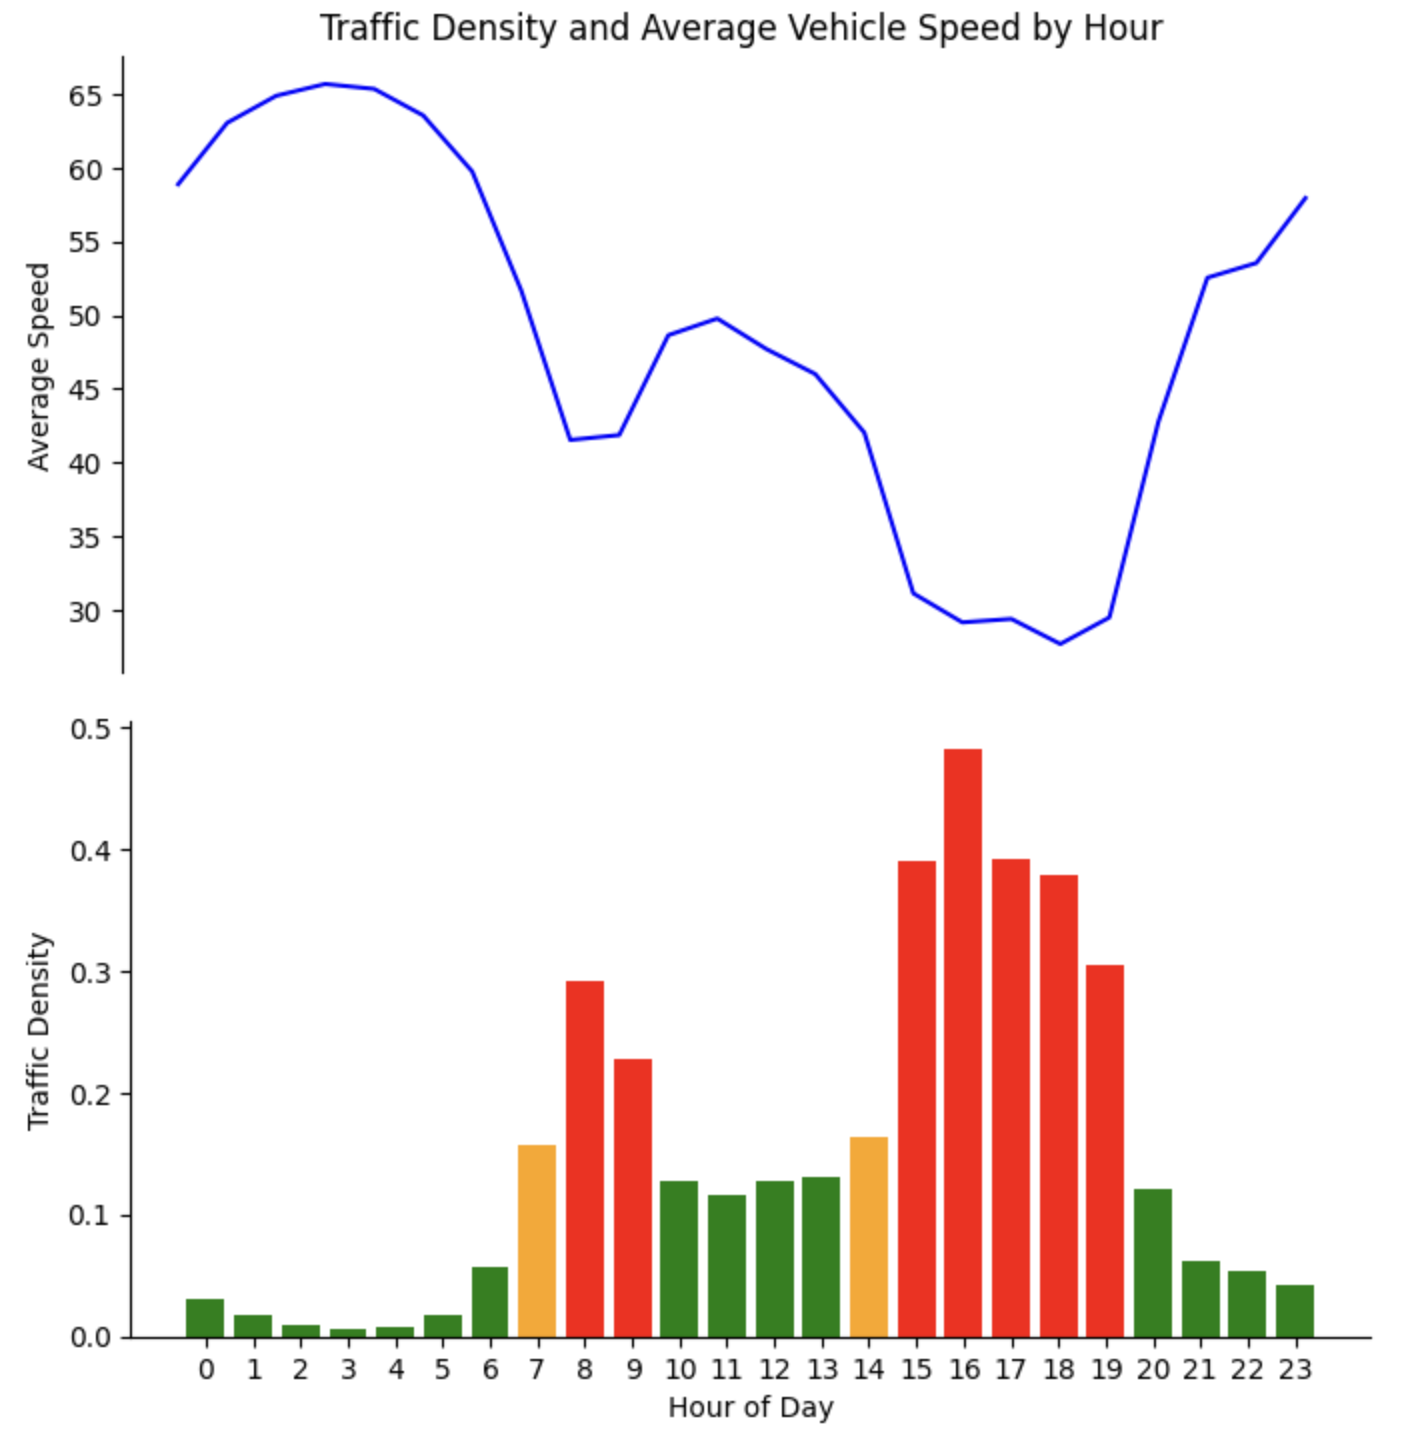
" alt="Traffic Density Plot" width="600" height="400"/> 




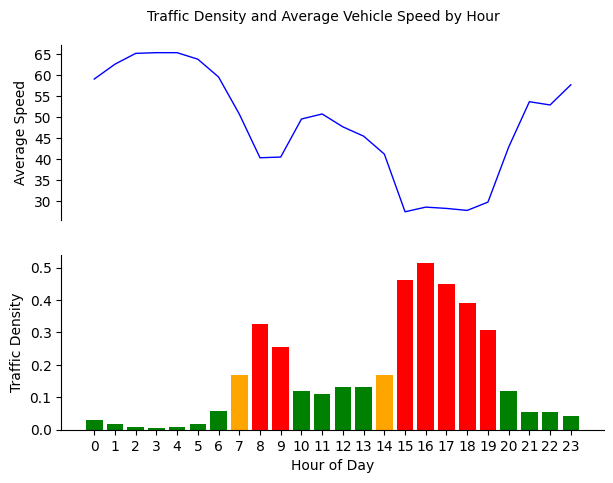

In [49]:
threshold = average_density * 0.1  # Calculate threshold as 10% of average density
# Assign colors based on how traffic density compares to the average density
colors = list()
for density in df["TRAFFIC_DENSITY"]:
    if abs(density - average_density) <= threshold:
        colors.append("orange")  # Color orange for densities within the threshold
    elif density > average_density:
        colors.append("red")     # Color red for densities above average
    else:
        colors.append("green")   # Color green for densities below average 
        
# Create a figure and set up GridSpec for layout
figure = plt.figure(figsize=(7, 5))
gs = figure.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.2)  

#Line graph for average speed above
ax1 = figure.add_subplot(gs[0])
ax1.plot(df["HOUR"], df["AVERAGE_SPEED"], color="blue", linewidth=1)  
ax1.set_ylabel("Average Speed", color="black") 
ax1.tick_params(axis="y", labelcolor="black")   
ax1.tick_params(axis="x", labelbottom=False, bottom=False)  # Hide x-axis ticks and labels for the upper axes
ax1.set_yticks(range(30, 70, 5))  # Set y-ticks from 30 to 65 to get expected output
# Remove top, right, and bottom spines to get expected graph
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

#Bar graph for traffic density below
ax2 = figure.add_subplot(gs[1], sharex=ax1) 
ax2.bar(df["HOUR"], df["TRAFFIC_DENSITY"], color=colors) 
ax2.set_xlabel("Hour of Day")  
ax2.set_ylabel("Traffic Density", color="black") 
ax2.tick_params(axis="y", labelcolor="black") 
ax2.set_xticks(range(24)) # Set x-ticks from 0 to 23 for hours of the day
ax2.set_xticklabels(range(24))
# Remove top and right spines to get expected graph
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Add a title to the figure
figure.suptitle("Traffic Density and Average Vehicle Speed by Hour", y=0.95,fontsize="medium")

#Show the plot
plt.show()


## Interpret the plot.

In [50]:
#Traffic density peaks between 7-9 AM and again around 5-7 PM, according to the graph. Higher traffic volumes may result from individuals commuting to work, school, and other required activities during these periods.

#The average speed is noticeably slower during these periods of heavy traffic.This decrease in speed is likely due to congestion, which limits the flow of vehicles and forces drivers to move more slowly.

#Low traffic density and faster speeds are observed during the late-night hours (12:00 AM to 6:00 AM), indicating that less congested roads allow faster travel.

#There is a comparatively steady period between 9 AM and 3 PM with moderate traffic density and faster speeds, which most likely reflects a mix of social and business travel rather than traveling traffic.

#Traffic density steadily drops after the evening rush, but it takes longer for speed to slow down, showing that there may still be some congestion as the roads gradually empty.